# Assignment 6 : Pretrain and Transfer Learning (20 pts)

### Before working on the assignment please read papers as following 
- SUPERVISED CONTRASTIVE LEARNING FOR PRE-TRAINED LANGUAGE MODEL FINE-TUNING
  - link: https://openreview.net/pdf?id=cu7IUiO
- Few-Shot Intent Detection via Contrastive Pre-Training and Fine-Tuning
  - link: https://arxiv.org/abs/2109.06349

## Question 1: Why do we need transfer learning ? (1.5pts)

## answer1

The needs of transfer learning is that we can learverage general knowledge from big data. The existing knowledge from that can adapt to new tasks easily and adress scarcity of data in production eg. imbalance, small data for each class.

## Question 2: When transfer learning makes sense ? (1.5pts)

## answer2
The transfer learning makes more sense when 
   1. we work on tasks that have a small amount of data.
   2. we have the assumption that downstream tasks related to the tasks that we transfer knowledge from 

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer, RobertaForSequenceClassification
from transformers import AdamW
import random
from IPython.display import clear_output
from utils import create_supervised_pair, supervised_contrasive_loss, Similarity
import matplotlib.pyplot as plt
import statistics

#comment this if you are not using puffer
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

## To download data from file directory both text samples and labels

In [2]:
def load_examples(file_path, do_lower_case=True):
    examples = []
    
    with open('{}/seq.in'.format(file_path),'r',encoding="utf-8") as f_text, open('{}/label'.format(file_path),'r',encoding="utf-8") as f_label:
        for text, label in zip(f_text, f_label):
            
            e = Inputexample(text.strip(),label=label.strip())
            examples.append(e)
            
    return examples

## Each sample has a sentence and label format

In [3]:
class Inputexample(object):
    def __init__(self,text_a,label = None):
        self.text = text_a
        self.label = label

### Question3 : Write the code to be able  to control batching data process for the sake of fine-tuning models with combining  cross entropy and supervised contrastive loss in question 5, and only cross entropy in question 4. (7pts)
    
 * assume : we have batch size = 4 but we have 64 classes, so sometime batching process will random sample in a batch, and then it has no any samples come from the same classes like below  
    
    * samples_sentence = ['a','b','c','d'] : assume that one alphabet represent one sentence or one sample
    * labels = [0,1,2,3] ; Therefore, if a batch has unqiue classes equal to batch size, this batch will be skipped due to equation "1yi=yj" of supervised contrastive loss(equation in question 5) that's reason why we need to force like below buttlet. 
    
  * you can see at least one pair that come from the same class.
    
    Therefore, we want dataloader to output like below 
   
    * samples_sentence = ['a','b','c','f'] 
    * labels = [0,1,2,0] ; this batch will pass condition as "1yi=yj" because the label of y[0] = 0, y[3] = 0 in list of labels.

In [4]:
# create custom dataset class
# ===  =  Hint =  ===
# can train on two condition 
# 1.) trainig training with supervise contrastive loss and cross entropy loss using in question 5.) 
#    when self.repeated_label == True:
# 2.) train only cross entropy loss use in question 4.)
#    when self.repeated_label == False:

class CustomTextDataset(Dataset):
    def __init__(self,labels,text,batch_size,repeated_label:bool=False):
        self.labels = labels
        self.text = text
        self.batch_size = batch_size 
        self.count = 0 
        self.batch_labels = []
        self.repeated_label = repeated_label
        
        if self.repeated_label == True:
            print("Train on Combine between Supervised Contrastive and Cross Entropy loss")
            
        else:
            print("Train on Cross Entropy loss")
            
        
        print("len of dataset :",len(self.labels))
              
     
          

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        
        
        # write code here for 1)
        if self.repeated_label == True:
        
            if len(np.unique(self.batch_labels)) == self.batch_size - 1:


                while True:
                    idx = np.random.choice(len(self.labels))

                    if self.labels[idx]  in self.batch_labels:

                       
                        break

        self.batch_labels.append(self.labels[idx])
        
        label = self.labels[idx]
        
        data = self.text[idx]
        
        sample = {"Class": label,"Text": data}


    
        return sample

### What is Few-shot Learning ?
   - few-shot learning is the process of train model on small amount of data in each class to guide model on specific taks, opposed to standard fine-tuning method which requires a large amount of training data for the pretrained model to adapt to the desired task with accuracy.
   
source : https://huggingface.co/blog/few-shot-learning-gpt-neo-and-inference-api

## Define Parameters

In [5]:
N = 5
data = []
labels = []

train_samples = []
train_labels = []

valid_samples = []
valid_labels = []

test_samples = []
test_labels = []

embed_dim = 768
batch_size = 4 
lr=2e-3  # you can adjust 
temp = 0.3  # you can adjust 
lamda = 0.01  # you can adjust  
skip_time = 0 # the number of time that yi not equal to yj in supervised contrastive loss equation 
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

### The Aim of these training is to fine tuning on few shot setting on text classification task

Path example of train, validation and test 

In [6]:
path_5shot = f'./HWU64/train_5/'
valid_path = f'./HWU64/valid/'
test_path = f'./HWU64/test/'

### Dataset Structure
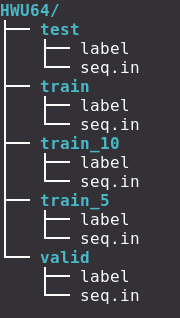

In [70]:
# Download data fewshot 
# https://downgit.github.io/#/home?url=https:%2F%2Fgithub.com%2Fjianguoz%2FFew-Shot-Intent-Detection%2Ftree%2Fmain%2FDatasets%2FHWU64

# load data
train_samples = load_examples(path_5shot)
valid_samples = load_examples(valid_path)
test_samples = load_examples(test_path)


print("===== small train set ====")

for i in range(len(train_samples)):
    data.append(train_samples[i].text)
    labels.append(train_samples[i].label)


train_data = CustomTextDataset(labels,data,batch_size=batch_size,repeated_label=False)
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)



print("===== validation set ====")

data = []
labels = []

for i in range(len(valid_samples)):
    data.append(valid_samples[i].text)
    labels.append(valid_samples[i].label)

valid_data = CustomTextDataset(labels,data,batch_size=batch_size,repeated_label=False)
valid_loader = DataLoader(valid_data,batch_size=batch_size,shuffle=True)



print("===== test set ====")

data = []
labels = []
    
for i in range(len(test_samples)):
    data.append(test_samples[i].text)
    labels.append(test_samples[i].label)

test_data = CustomTextDataset(labels,data,batch_size=batch_size,repeated_label=False)
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=True)



# got the number of unique classes from dataset
num_class = len(np.unique(np.array(labels)))

# get text label of uniqure classes
unique_label = np.unique(np.array(labels))

# map text label to index classes
label_maps = {unique_label[i]: i for i in range(len(unique_label))}

===== small train set ====
Train on Cross Entropy loss
len of dataset : 1396
===== validation set ====
Train on Cross Entropy loss
len of dataset : 1076
===== test set ====
Train on Cross Entropy loss
len of dataset : 1076


### The statistics of Dataset

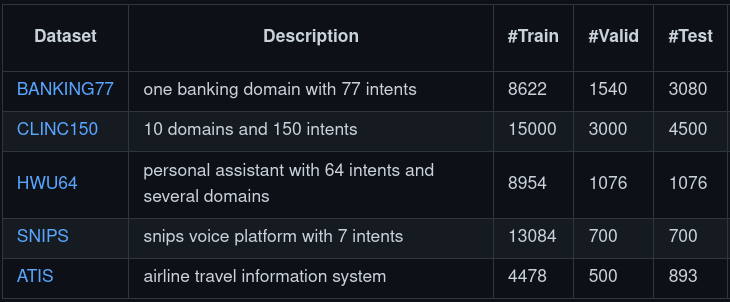

In [8]:
# Download tokenizer that use to tokenize sentence into words by using Pretrain from roberta-base
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

## Question3: write function to freeze model (3pts)


In [9]:
def freeze_layers(model,freeze_layers_count:int=0):

        """
        model : model object that we create 
        freeze_layers_count : the number of layers to freeze 
        """
        # write the code here
    
        # should not more than the number of layers in a backbone
        assert freeze_layers_count <= 12

        for name, param in model.named_parameters():
           

            keys = name.split(".")

            if str(freeze_layers_count) in keys or 'classifier' in keys:
                break
            
            param.requires_grad = False 


        #print all parameter that we want to train from scratch 
        
        for name, param in model.named_parameters():
            
            if param.requires_grad == True:
                 
                print(name)
        
    
        return model     

### Train with Cross Entropy loss 

### Test function

In [105]:
#  no gradients needed
def test(model,test_loader,data_size):
    
    correct = 0
         
    with torch.no_grad():
        for (idx, batch) in enumerate(test_loader):
            sentence = batch["Text"]
            inputs = tokenizer(sentence,padding=True,truncation=True,return_tensors="pt")

            # move parameter to device
            inputs = {k:v.to(device) for k,v in inputs.items()}

            # map string labels to class idex
            labels = [label_maps[stringtoId] for stringtoId in (batch['Class'])]

            # convert list to tensor
            labels = torch.tensor(labels).unsqueeze(0)
            labels = labels.to(device)
            
            # Foward pass 
            outputs = model(**inputs,labels=labels)

            # get loss and output 
            loss, logits = outputs[:2]
            
            _, predicted = torch.max(logits, -1)
            
            
           
         
            correct += (predicted == labels).sum().item()
            
    print("correct :",correct)
    print("total :",data_size)
         
    return correct / data_size

## Question4: Training on text classification task on CrossEntropy loss (3.5 pts)
- Using API of hugging face of RobertaForSequenceClassification
  - source : https://huggingface.co/transformers/v3.0.2/model_doc/roberta.html#robertaforsequenceclassification
- report performance of models (test acc) with differrent experiement of unfreezing of bottom layers and compare the result of each
    - 4.1. freeze weight from pretrain model all layer except classifier 
    - 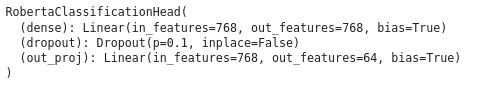
    
   
    - 4.2. freeze all from top embeddings to encoder layers (9)
      - embeddings
        - 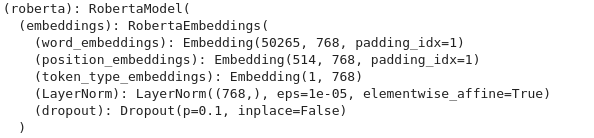
      - layer 9
        - 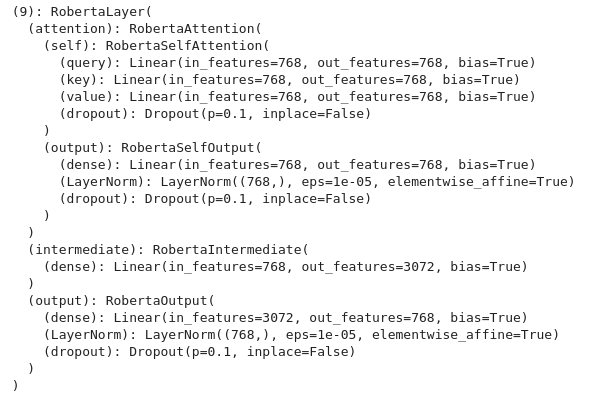
    - 4.3 add code to collect loss and accuracy of training history  of (4.1 and 4.2)
    - 4.4 add the code in below in training loop collect validation loss and accuracy history of (4.1 and 4.2)
    
- hint: for this training on Cross entropy loss no need to control the outcome of class in each batch using code below to train model base on how many layers that you freeze  
  - to see whole architecture look like you can use mode.eval() 

In [109]:
def train(model,optimizer,train_loader,valid_loader,epochs:int=30):

    train_loss_hist = [] 
    valid_loss_hist = []
    
    train_acc_hist = []
    valid_acc_hist = []
    

    test_acc = []

    min_valid_loss = np.inf
   
    for e in range(epochs):  # loop over the dataset multiple times

       
        model.train()
        correct = 0
        running_loss = 0.0
       
    
        for (idx, batch) in enumerate(train_loader):
            sentence = batch["Text"]
            inputs = tokenizer(sentence,padding=True,truncation=True,return_tensors="pt")


            #assert len(np.unique(batch["Class"])) < len(batch["Class"])  
            # move parameter to device
            inputs = {k:v.to(device) for k,v in inputs.items()}

            # map string labels to class idex
            labels = [label_maps[stringtoId] for stringtoId in (batch['Class'])]

            # convert list to tensor
            labels = torch.tensor(labels).unsqueeze(0)
            labels = labels.to(device)


             # clear gradients
            optimizer.zero_grad()

            # Foward pass 
            outputs = model(**inputs,labels=labels)

            # get loss and output 
            loss, logits = outputs[:2]
            
            
            # Calculate gradients
            loss.backward()
            
           # Update Weights
            optimizer.step()
            
            # Calculate Loss
            running_loss += loss.item()
            
            #calculate nums of correction 
            correct += (torch.max(logits,dim=-1)[1] == labels).sum()
            
           
            
            #clear_output(wait=True)
        
        train_loss_hist.append(running_loss/len(train_data))
        train_acc_hist.append(correct/len(train_data))
        
        
        print(f'======  Epoch {e+1} ====== ')
        print(f' Training Loss: {running_loss/len(train_data)}, \t\t Training acc: {correct/len(train_data)}')
        
        print("train correct : ",correct)
        print("train total :",len(train_data))
        
        running_loss = 0.0
        correct = 0
        model.eval()     # Optional when not using Model Specific layer
        log_correct = []
        
        
        for (idx, batch) in enumerate(valid_loader):

            sentence = batch["Text"]
            inputs = tokenizer(sentence,padding=True,truncation=True,return_tensors="pt")

            # move parameter to device
            inputs = {k:v.to(device) for k,v in inputs.items()}

            # map string labels to class idex
            labels = [label_maps[stringtoId] for stringtoId in (batch['Class'])]

            # convert list to tensor
            labels = torch.tensor(labels).unsqueeze(0)
            labels = labels.to(device)

            # Foward pass 
            outputs = model(**inputs,labels=labels)

            # get loss and output 
            loss, logits = outputs[:2]
        
            
            # Calculate Loss
            running_loss += loss.item()
            
            #calculate nums of correction 
            correct += (torch.max(logits,dim=-1)[1] == labels).sum()
            
           
        #  add to collect log 
        
        valid_loss_hist.append(running_loss/len(valid_data))
        valid_acc_hist.append(correct/len(valid_data))
        
        print(f' Validation Loss: {running_loss/len(valid_data)}, \t\t Validation acc: {correct/len(valid_data)}')
        
        print("valid correct : ",correct)
        print("valid total :",len(valid_data))
       
        # save best current model 
        if min_valid_loss > (running_loss/len(valid_data)):
            print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{running_loss/len(valid_data):.6f}) \t Saving The Model')
            min_valid_loss = running_loss/len(valid_data) 
            torch.save(model.state_dict(), 'saved_model.pth')
            
           
    return (train_acc_hist, train_loss_hist), (valid_acc_hist, valid_loss_hist)  

### 4.1   freeze all from top embeddings to encoder 12 layers 

In [92]:
# download config of Roberta config 
config = RobertaConfig.from_pretrained("roberta-base",output_hidden_states=True)

#chnage modifying the number of classes
config.num_labels = num_class

# Download pretrain models weight 
model = RobertaForSequenceClassification.from_pretrained('roberta-base')

# change from binary classification to muli-classification and loss automatically change to cross entropy loss
model.num_labels = config.num_labels

# change the output of last layer to num_class that we want to predict
model.classifier.out_proj = nn.Linear(in_features=embed_dim,out_features=num_class)

# move to model to device that we set
model = model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [93]:
model = freeze_layers(model,freeze_layers_count=12)
# Using adam optimizer 
optimizer= AdamW(model.parameters(), lr=lr)

classifier.dense.weight
classifier.dense.bias
classifier.out_proj.weight
classifier.out_proj.bias


In [94]:
train_log, valid_log = train(model,optimizer,train_loader,valid_loader,epochs=30)

======  Epoch 1 ====== 
 Training Loss: 1.0603402987933774, 		 Training acc: 0.04369627684354782
train correct :  tensor(61, device='cuda:2')
train total : 1396
Epoch 1 		 Validation Loss: 0.9198136927913113, 		 Validation acc: 0.07156133651733398
valid correct :  tensor(77, device='cuda:2')
valid total : 1076
Validation Loss Decreased(inf--->0.919814) 	 Saving The Model
======  Epoch 2 ====== 
 Training Loss: 0.8722588259374515, 		 Training acc: 0.14541548490524292
train correct :  tensor(203, device='cuda:2')
train total : 1396
Epoch 2 		 Validation Loss: 0.6966058503296295, 		 Validation acc: 0.28438660502433777
valid correct :  tensor(306, device='cuda:2')
valid total : 1076
Validation Loss Decreased(0.919814--->0.696606) 	 Saving The Model
======  Epoch 3 ====== 
 Training Loss: 0.7268417575810222, 		 Training acc: 0.24068768322467804
train correct :  tensor(336, device='cuda:2')
train total : 1396
Epoch 3 		 Validation Loss: 0.5849021335295141, 		 Validation acc: 0.31412640213966

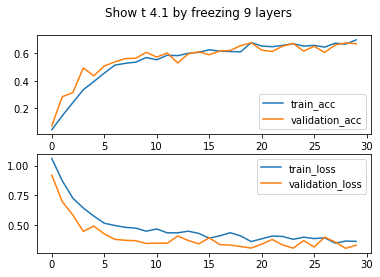

In [101]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Show t 4.1 by freezing 12 layers')
ax1.plot(torch.tensor(train_log[0] , device = 'cpu').tolist())
ax1.plot(torch.tensor(valid_log[0] , device = 'cpu').tolist())
ax1.legend(['train_acc','validation_acc'])
ax2.plot(torch.tensor(train_log[1] , device = 'cpu').tolist())
ax2.plot(torch.tensor(valid_log[1] , device = 'cpu').tolist())
ax2.legend(['train_loss','validation_loss'])

In [106]:
test_acc = test(model,test_loader=test_loader,data_size=len(test_data))

correct : 911
total : 1076


In [108]:
print(f'Accuracy : {100 * test_acc} %') 

Accuracy : 84.66542750929368 %


### 4.2   freeze all from top embeddings to encoder layers (9)

In [110]:
# download config of Roberta config 
config = RobertaConfig.from_pretrained("roberta-base",output_hidden_states=True)

#chnage modifying the number of classes
config.num_labels = num_class
# Download pretrain models weight 
model = RobertaForSequenceClassification.from_pretrained('roberta-base')
# change from binary classification to muli-classification and loss automatically change to cross entropy loss
model.num_labels = config.num_labels
# change the output of last layer to num_class that we want to predict
model.classifier.out_proj = nn.Linear(in_features=embed_dim,out_features=num_class)
# move to model to device that we set
model = model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [111]:
## Fine-Tune  model on SuperVised Contrastive loss 
# 5.1 freeze weight from pretrain model all layer except classifier 
model = freeze_layers(model,freeze_layers_count=9)
# Using adam optimizer 
optimizer= AdamW(model.parameters(), lr=lr)

roberta.encoder.layer.9.attention.self.query.weight
roberta.encoder.layer.9.attention.self.query.bias
roberta.encoder.layer.9.attention.self.key.weight
roberta.encoder.layer.9.attention.self.key.bias
roberta.encoder.layer.9.attention.self.value.weight
roberta.encoder.layer.9.attention.self.value.bias
roberta.encoder.layer.9.attention.output.dense.weight
roberta.encoder.layer.9.attention.output.dense.bias
roberta.encoder.layer.9.attention.output.LayerNorm.weight
roberta.encoder.layer.9.attention.output.LayerNorm.bias
roberta.encoder.layer.9.intermediate.dense.weight
roberta.encoder.layer.9.intermediate.dense.bias
roberta.encoder.layer.9.output.dense.weight
roberta.encoder.layer.9.output.dense.bias
roberta.encoder.layer.9.output.LayerNorm.weight
roberta.encoder.layer.9.output.LayerNorm.bias
roberta.encoder.layer.10.attention.self.query.weight
roberta.encoder.layer.10.attention.self.query.bias
roberta.encoder.layer.10.attention.self.key.weight
roberta.encoder.layer.10.attention.self.key.b

In [ ]:
# train_log, valid_log = 
train_log, valid_log = train(model,optimizer,train_loader,valid_loader,epochs=30)

======  Epoch 1 ====== 
 Training Loss: 1.4000346763086182, 		 Training acc: 0.01074498612433672
train correct :  tensor(15, device='cuda:2')
train total : 1396
 Validation Loss: 1.3804691351922471, 		 Validation acc: 0.017657991498708725
valid correct :  tensor(19, device='cuda:2')
valid total : 1076
Validation Loss Decreased(inf--->1.380469) 	 Saving The Model
======  Epoch 2 ====== 
 Training Loss: 1.4472739296861228, 		 Training acc: 0.020057307556271553
train correct :  tensor(28, device='cuda:2')
train total : 1396
 Validation Loss: 1.335245218861945, 		 Validation acc: 0.017657991498708725
valid correct :  tensor(19, device='cuda:2')
valid total : 1076
Validation Loss Decreased(1.380469--->1.335245) 	 Saving The Model
======  Epoch 3 ====== 
 Training Loss: 1.4056283145032844, 		 Training acc: 0.013610315509140491
train correct :  tensor(19, device='cuda:2')
train total : 1396
 Validation Loss: 1.4018656757684445, 		 Validation acc: 0.011152416467666626
valid correct :  tensor(1

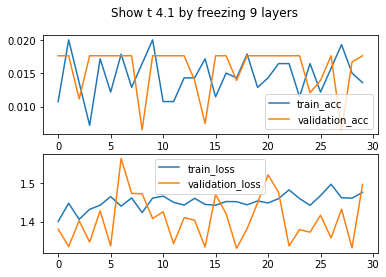

In [114]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Show t 4.1 by freezing 9 layers')
ax1.plot(torch.tensor(train_log[0] , device = 'cpu').tolist())
ax1.plot(torch.tensor(valid_log[0] , device = 'cpu').tolist())
ax1.legend(['train_acc','validation_acc'])
ax2.plot(torch.tensor(train_log[1] , device = 'cpu').tolist())
ax2.plot(torch.tensor(valid_log[1] , device = 'cpu').tolist())
ax2.legend(['train_loss','validation_loss'])

In [115]:
test_acc = test(model,test_loader=test_loader,data_size=len(test_data))

correct : 19
total : 1076


In [116]:
print(f'Accuracy : {100 * test_acc} %') 

Accuracy : 1.7657992565055762 %
